In [ ]:
!pip install -q boto3

In [39]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

### Balanced

In [40]:
prefix_train = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train'
prefix_validation = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation'
prefix_test = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test'

balanced_tfidf_without_header_train_s3_uri = 's3://{}/{}'.format(bucket, prefix_train)
balanced_tfidf_without_header_validation_s3_uri = 's3://{}/{}'.format(bucket, prefix_validation)
balanced_tfidf_without_header_test_s3_uri = 's3://{}/{}'.format(bucket, prefix_test)

s3_input_train_data = sagemaker.s3_input(s3_data=balanced_tfidf_without_header_train_s3_uri, content_type='text/csv')
s3_input_validation_data = sagemaker.s3_input(s3_data=balanced_tfidf_without_header_validation_s3_uri, content_type='text/csv')
s3_input_test_data = sagemaker.s3_input(s3_data=balanced_tfidf_without_header_test_s3_uri, content_type='text/csv')

print(s3_input_train_data.config)
print(s3_input_validation_data.config)
print(s3_input_test_data.config)

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'text/csv'}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'text/csv'}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'text/csv'}


### Scrubbed

In [41]:
# prefix_train = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/train'
# prefix_validation = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/validation'
# prefix_test = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/test'

# scrubbed_tfidf_without_header_train_s3_uri = 's3://{}/{}'.format(bucket, prefix_train)
# scrubbed_tfidf_without_header_validation_s3_uri = 's3://{}/{}'.format(bucket, prefix_validation)
# scrubbed_tfidf_without_header_test_s3_uri = 's3://{}/{}'.format(bucket, prefix_test)

# s3_input_train_data = sagemaker.s3_input(s3_data=scrubbed_tfidf_without_header_train_s3_uri, content_type='text/csv')
# s3_input_validation_data = sagemaker.s3_input(s3_data=scrubbed_tfidf_without_header_validation_s3_uri, content_type='text/csv')
# s3_input_test_data = sagemaker.s3_input(s3_data=scrubbed_tfidf_without_header_test_s3_uri, content_type='text/csv')

# print(s3_input_train_data.config)
# print(s3_input_validation_data.config)
# print(s3_input_test_data.config)

In [42]:
from sagemaker.amazon.amazon_estimator import get_image_uri 
import json

# get the URI for new container
builtin_container_uri = get_image_uri(region_name=region,                                
                                      repo_name='xgboost', 
                                      repo_version='0.90-2')
print(builtin_container_uri)

model_output_path = 's3://{}/models/built-in/training-runs'.format(bucket)
print(model_output_path)

xgb_estimator = sagemaker.estimator.Estimator(image_name=builtin_container_uri, 
                                              role=role, 
                                              train_instance_count=2, 
                                              train_instance_type='ml.m4.xlarge', 
                                              output_path=model_output_path, 
                                              sagemaker_session=sess,
                                              #enable_cloudwatch_metrics=True
                                             )

xgb_estimator.set_hyperparameters(objective='binary:logistic',
                                  num_round=1,
                                  max_depth=5)
#                                  objective='binary:hinge',
#                                  alpha=0.00005132135252330067,
#                                  colsample_bytree=0.3,
#                                  eta=0.26598827064546426,
#                                  gamma=8.161691281008395,
#                                  max_depth=6,
#                                  min_child_weight=0.0000034330126876522306,
#                                  num_round=347,
#                                  subsample=0.9088373868921568
#                                 )


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3
s3://sagemaker-us-east-1-835319576252/models/built-in/training-runs


In [43]:
xgb_estimator.fit({'train': s3_input_train_data,
                   'validation': s3_input_validation_data
                  }
                  #, wait=False
                 )

2020-03-09 06:38:40 Starting - Starting the training job...
2020-03-09 06:38:42 Starting - Launching requested ML instances......
2020-03-09 06:39:45 Starting - Preparing the instances for training......
2020-03-09 06:40:52 Downloading - Downloading input data...
2020-03-09 06:41:28 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[06:41:51] 32644x300 matrix with 9793200 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter

In [44]:
training_job_name = xgb_estimator.latest_training_job.name
print('training_job_name:  {}'.format(training_job_name))

training_job_name:  sagemaker-xgboost-2020-03-09-06-38-40-765


In [45]:
# TODO:  This is broken
#from sagemaker.xgboost import XGBoost

#xgb_estimator = XGBoost.attach(training_job_name=training_job_name)

# Load the Model

In [46]:
# download the model artifact from AWS S3
!aws s3 cp $model_output_path/$training_job_name/output/model.tar.gz ./models/built-in/

download: s3://sagemaker-us-east-1-835319576252/models/built-in/training-runs/sagemaker-xgboost-2020-03-09-06-38-40-765/output/model.tar.gz to models/built-in/model.tar.gz


In [47]:
import tarfile
import pickle as pkl

tar = tarfile.open('./models/built-in/model.tar.gz')
tar.extractall(path='./models/built-in/')
tar.close()

In [48]:
!ls -al ./models/built-in/

total 20
drwxrwxr-x 2 ec2-user ec2-user 4096 Mar  9 06:42 .
drwxrwxr-x 5 ec2-user ec2-user 4096 Mar  9 05:55 ..
-rw-rw-r-- 1 ec2-user ec2-user 2634 Mar  9 06:42 model.tar.gz
-rw-r--r-- 1 ec2-user ec2-user 6110 Mar  9 06:41 xgboost-model


In [49]:
import pickle as pkl

model_dir = './models/built-in'
model_path = os.path.join(model_dir, 'xgboost-model')

xgb_estimator_restored = pkl.load(open(model_path, 'rb'))

type(xgb_estimator_restored) 

xgboost.core.Booster

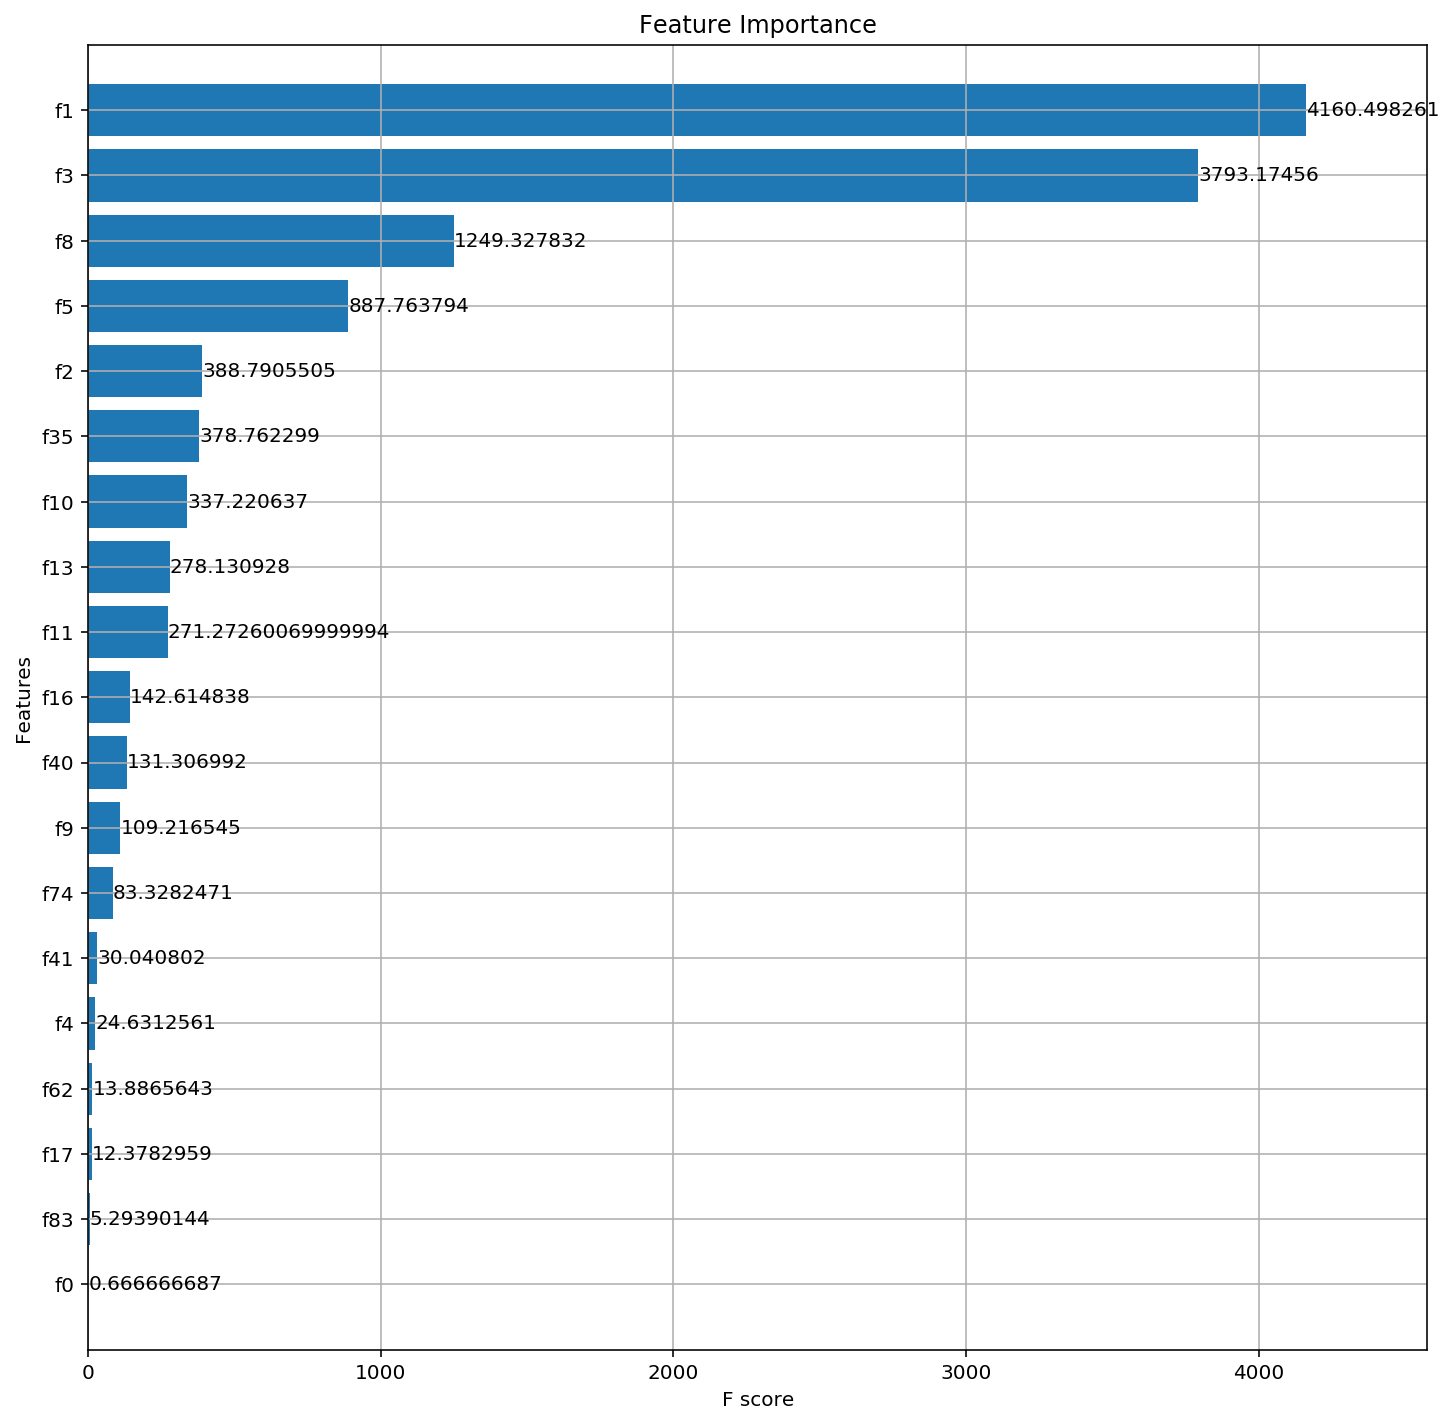

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import xgboost

fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(xgb_estimator_restored, 
                        importance_type='gain', 
                        max_num_features=30, 
                        height=0.8, 
                        ax=ax, 
                        show_values = True)
plt.title('Feature Importance')
plt.show()

#  Calculate Test Metrics

## Load Test Dataset

In [ ]:
# $S3_BUCKET/feature-store/amazon-reviews/csv/balanced-tfidf-without-header

prefix_test = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test'
#prefix_test = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/test'

#scrubbed_tfidf_without_header_test_path = './{}'.format(prefix_test)
balanced_tfidf_without_header_test_path = './{}'.format(prefix_test)

import os
os.makedirs(prefix_test, exist_ok=True)

#scrubbed_tfidf_without_header_test_s3_uri = 's3://{}/{}'.format(bucket, prefix_test)
balanced_tfidf_without_header_test_s3_uri = 's3://{}/{}'.format(bucket, prefix_test)

In [ ]:
#!aws s3 cp --recursive $scrubbed_tfidf_without_header_test_s3_uri $scrubbed_tfidf_without_header_test_path
!aws s3 cp --recursive $balanced_tfidf_without_header_test_s3_uri $balanced_tfidf_without_header_test_path

In [ ]:
import glob
import pandas as pd

def load_dataset(path, sep, header):
    data = pd.concat([pd.read_csv(f, sep=sep, header=header) for f in glob.glob('{}/*.csv'.format(path))], ignore_index = True)

    labels = data.iloc[:,0]
    features = data.drop(data.columns[0], axis=1)
    
    if header==None:
        # Adjust the column names after dropped the 0th column above
        # New column names are 0 (inclusive) to len(features.columns) (exclusive)
        new_column_names = list(range(0, len(features.columns)))
        features.columns = new_column_names

    return features, labels

In [ ]:
X_test, y_test = load_dataset(path=balanced_tfidf_without_header_test_path, sep=',', header=None)
X_test.shape

In [ ]:
X_test.head(5)

In [ ]:
# Must convert pandas dataframe to XGBoost DMatrix before predicting
preds_test = xgb_estimator_restored.predict(X_test)
preds_test.shape

### Convert probability values into classification (0 or 1) using threshold 0.5

In [ ]:
import numpy as np
preds_test_0_or_1 = np.where(preds_test > 0.5, 1, 0)
preds_test_0_or_1.shape

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Test Accuracy: ', accuracy_score(y_test, preds_test_0_or_1))
print('Test Precision: ', precision_score(y_test, preds_test_0_or_1, average=None))

In [ ]:
print(classification_report(y_test, preds_test_0_or_1))

In [ ]:
df_cm_test = confusion_matrix(y_test, preds_test_0_or_1)
df_cm_test

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(df_cm_test, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

In [ ]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_test, preds_test_0_or_1), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, preds_test_0_or_1)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Hyper Parameter Tuning

In [ ]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

# Define exploration boundaries (default suggested values from Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000, scaling_type="Auto"),
    'colsample_bylevel': ContinuousParameter(0.1, 1,scaling_type="Logarithmic"),
    'colsample_bytree': ContinuousParameter(0.5, 1, scaling_type='Logarithmic'),
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':ContinuousParameter(0, 5, scaling_type='Auto'),
    'lambda': ContinuousParameter(0,100,scaling_type='Auto'),
    'max_delta_step': IntegerParameter(0,10,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'num_round': IntegerParameter(1,4000,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic')}

objective_metric_name = 'validation:auc'

tuner_log = HyperparameterTuner(
    xgb_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=60,
    max_parallel_jobs=10,
    strategy='Bayesian'
)

## Start the hyperparameter tuning job

In [ ]:
tuner_log.fit({'train': balanced_tfidf_without_header_train_s3_uri, 
               'validation': balanced_tfidf_without_header_validation_s3_uri}, 
               include_cls_metadata=False)

In [ ]:
## Prints the status of the latest hyperparameter tuning job
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']


# Deploy Endpoint

### From an external application, you can use the following code to make a prediction

In [ ]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [ ]:
import time

# https://towardsdatascience.com/xgboost-in-amazon-sagemaker-28e5e354dbcd
from sagemaker.predictor import csv_serializer

xgb_endpoint_name = 'xgboost-built-in-{}'.format(time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime()))
xgb_endpoint_name

In [ ]:
## Deploy trained XGBoost model endpoint to perform predictions
xgb_predictor = xgb_estimator.deploy(initial_instance_count = 1, 
                                     instance_type = 'ml.m4.xlarge',
                                     endpoint_name=xgb_endpoint_name)

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

sm_runtime = boto3.client('sagemaker-runtime')

payload_500_samples = X_test[:500].to_csv(index=False, header=False).rstrip()

response_500_samples = sm_runtime.invoke_endpoint(
    EndpointName=xgb_endpoint_name,
    Body=payload.encode('utf-8'),
    ContentType='text/csv')['Body'].read()

In [ ]:
predictions_500_samples = np.fromstring(response_500_samples, sep=',')
predictions_500_samples_0_or_1 = np.where(predictions_500_samples > 0.5, 1, 0)

In [ ]:
print('Test Accuracy: ', accuracy_score(y_test[:500], predictions_500_samples_0_or_1))
print('Test Precision: ', precision_score(y_test[:500], predictions_500_samples_0_or_1, average=None))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_test = confusion_matrix(y_test[:500], predictions_500_samples_0_or_1)
df_cm_test

In [ ]:
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(df_cm_test, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

In [ ]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_test, preds_test), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, preds_test)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# TODO:  XGBoostPredictor

In [ ]:
# TODO:  1) update this to do TF/IDF
#        2) use this in other versions of the model
# Derived from the following:
#   https://aim357.readthedocs.io/en/latest/GluePySparkMLFeatureEngineering/GluePySparkMLFeatureEngineering.html#deepar-deep-dive

class XGBoostPredictor(sagemaker.predictor.RealTimePredictor):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)

    def predict(self, ts, cat=None, dynamic_feat=None,
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }

        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }

        return json.dumps(http_request_data).encode('utf-8')

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq

def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

In [ ]:
xgb_endpoint_name = prefix + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

xgb_predictor = xgb_estimator.deploy(
                     initial_instance_count=1, 
                     instance_type='ml.m4.xlarge',
                     predictor_cls=XGBoostPredictor,
                     endpoint_name=xgb_endpoint_name)

In [ ]:
predictions, raw_outputs = model.predict(["""Very funny. A typical mid 50's comedy."""])
print('Predictions: {}'.format(predictions))
print('Raw outputs: {}'.format(raw_outputs))

In [ ]:
predictions, raw_outputs = bert_model.predict(["""That movie was absolutely awful."""])
print('Predictions: {}'.format(predictions))
print('Raw outputs: {}'.format(raw_outputs))